# Text Representation and Information Retrieval
**Internet Analytics - Lab 4**

---

**Group:** *H*

**Names:**

* *Baffou Jérémy*
* *Basseto Antoine*
* *Pinto Andrea*

---
# 4.1 Vector Space Models

In [1]:
import re
import pickle
import string
import nltk
import numpy as np

In [2]:
import matplotlib.pyplot as plt 
from scipy.sparse import csr_matrix
from utils import load_json, load_pkl

In [3]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

In [4]:
courses = load_json('data/courses.txt')
stopwords = load_pkl('data/stopwords.pkl')

---
## Exercise 4.1: Pre-processing

### Cleaning description content

In [5]:
"""Preprocess text description
@param: (description) Dirty string text
@return: Cleaned array of words
"""
def preprocess(description):
    # Preprocess courses descriptions
    split_joined_words = re.sub(r'([a-z])([A-Z])', r'\1 \2', description)
    split_3D_occurences = re.sub(r'3D', r' 3D ', split_joined_words)
    stick_phd_occurences = re.sub(r'Ph D', r'PhD', split_3D_occurences)
    cleaned_dataset = stick_phd_occurences
    
    # Remove punctuations and lowercase
    cleaned_dataset = [
        word.casefold() for word in cleaned_dataset
        .translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        .split()
    ]
    
    # Remove stopwords and digits
    cleaned_dataset = [
        word for word in cleaned_dataset 
        if word not in stopwords and not word.isdigit()
    ]
    
    return cleaned_dataset

In [6]:
"""Clean courses RDD
@param: (courses_rdd) Dirty courses RDD
@return: Cleaned courses RDD
"""
def clean_rdd(courses_rdd):
    return courses_rdd.map(
        lambda c: {
            'courseId': c['courseId'],
            'name': c['name'],
            'description': preprocess(c['description'])
        }
    )

In [7]:
courses_rdd = sc.parallelize(courses)
courses_preprocessed_rdd = clean_rdd(courses_rdd)

### Lemming description content

In [8]:
tag_dict = {
    'J': wordnet.ADJ, 
    'N': wordnet.NOUN, 
    'V': wordnet.VERB, 
    'R': wordnet.ADV
}

In [9]:
def tag_mapper(tag):
    return tag_dict[tag] if tag in tag_dict else wordnet.NOUN

In [10]:
"""Lemmatize word list
@param: (words) List of words to lemmatize
@param: (lm) Used Lemmatizer for computations
@return: List of lemmatized words
"""
def lemmatize(words, lm):
    word2tag = nltk.pos_tag(words)
    lemmatized = list(map(lambda x: lm.lemmatize(x[0], tag_mapper(x[1][0])), word2tag))
    return lemmatized

In [11]:
"""Lemmatize courses RDD
@param: (courses_rdd) Courses RDD
@param: (lm) Used Lemmatizer for computations
@return: RDD with lemmatized courses descriptions
"""
def lemmatize_rdd(courses_rdd, lm):
    courses_lemmatized = list(
        map(lambda c: {
            "courseId": c["courseId"],
            "name" : c["name"],
            "description" : lemmatize(c["description"], lm)
        }, courses_rdd.collect())
    )
    return sc.parallelize(courses_lemmatized)

Note that we collected the dataset in the `lemmatize_rdd` because we couldnt figure how to have `wordnet` downloaded on every workers.

In [12]:
lm = WordNetLemmatizer()

In [13]:
courses_lemmatized_rdd = lemmatize_rdd(courses_preprocessed_rdd, lm)

### Stemming description content

In [14]:
"""Stem word list
@param: (words) List of words to stem
@param: (lm) Used Stemmer for computations
@return: List of stemmed words
"""
def stem(words, ps):
    return list(map(lambda w : ps.stem(w), words))

In [15]:
ps = PorterStemmer()

In [16]:
courses_stemmed_rdd = courses_lemmatized_rdd.map(
    lambda c: {
        "courseId": c["courseId"], 
        "name" : c["name"], 
        "description" : stem(c["description"], ps)
    }
)

Note that we are not sure about stemming here. Porter Stemmer can cut words and group them into bigger groups. i.e. words `work` and `working` will both be mapped to `work` which is not done by the lemmatizer here. However it sometimes cut too much and we are loosing some of the meaning.

### Create n-grams

In [17]:
def ngram(words, n):
    return [" ".join(map(str, x)) for x in ngrams(words, n)]

In [18]:
def ngram_rdd(courses_rdd, n):
    return courses_rdd.map(
        lambda c: {
            "courseId": c["courseId"], 
            "name": c["name"], 
            "description": [w for i in range(1, n + 1) for w in ngram(c['description'], i)]
        }
    )

In [19]:
courses_ngram_rdd = ngram_rdd(courses_lemmatized_rdd, 3)

### Frequency analysis over corpus

In [20]:
"""Frequency analysis of given corpus
@param: (corpus) RDD of list of words
@return: RDD of list of (frequency ratio, word) tuples
@return: Number of words in the corpus
"""
def frequency_analysis(corpus):
    count = corpus.count()
    freqs2word_rdd = (
        corpus
        .map(lambda word: (word, 1))
        .reduceByKey(lambda x, y: x + y)
        .map(lambda x: (x[1] / count, x[0]))
        .sortByKey(False)
    )
    return freqs2word_rdd, count

In [21]:
"""Plot frequency analysis
@param: (freqs) List of word frequencies
@param: (count) Number of words in total
"""
def plot_frequency_analysis(freqs, count):
    fig, axs = plt.subplots(1, 2, figsize=(16,4))
    axs[0].set_ylabel("Log frequency")
    axs[0].plot(np.arange(len(freqs)), np.log(list(map(lambda f: f*count, freqs))))
    axs[1].boxplot(freqs)
    fig.show()

In [22]:
corpus = courses_ngram_rdd.flatMap(lambda c: c["description"])
freqs2word_rdd, count = frequency_analysis(corpus)
freqs = np.asarray(freqs2word_rdd.map(lambda x: x[0]).collect())

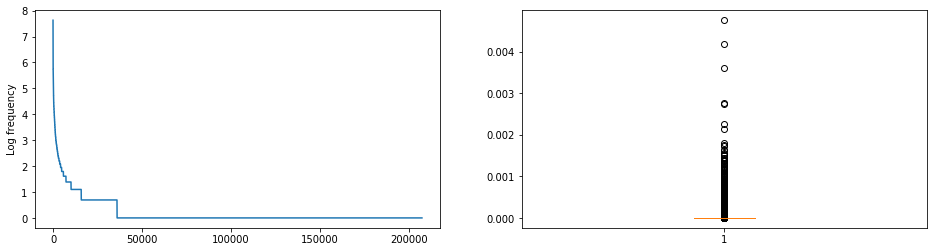

In [23]:
plot_frequency_analysis(freqs, count)

We want to erase words that are too frequent over the corpus as they are unlikely to differentiate further documents. We choose to keep only the words which were under the `0.995` quantile because it corresponds more or less to the big vertical bar at the beginning in the frequencies plot.

In [24]:
def frequent_words(freqs2word_rdd, freqs, quantile):
    indices = np.where(freqs > np.quantile(freqs, quantile))[0]
    frequent = freqs2word_rdd.take(indices[-1])
    frequent_words = set(map(lambda x: x[1], frequent))
    return frequent_words

In [25]:
def rare_words(freqs2word_rdd, count, apparitions):
    rare = freqs2word_rdd.filter(lambda x: x[0]*count == apparitions)
    rare_words = set(rare.map(lambda x: x[1]).collect())
    return rare_words

In [26]:
def remove_rdd(courses_rdd, words):
    return courses_rdd.map(
        lambda c: {
            "courseId": c["courseId"],
            "name": c["name"],
            "description": [w for w in c["description"] if w not in words]
        }
    )

In [27]:
fw = frequent_words(freqs2word_rdd, freqs, 0.995)
rw = rare_words(freqs2word_rdd, count, 1)

**Note:** Because rare words are a large part of the dataset, we decided to only cut frequent words.

In [28]:
print(f'{len(fw)} of frequent words out of {freqs2word_rdd.count()} total words.')
print(f'{len(rw)} of rare words out of {freqs2word_rdd.count()} total words.')

1021 of frequent words out of 207231 total words.
171298 of rare words out of 207231 total words.


In [29]:
lengths = [0] * 3
for elem in fw:
    index = len(re.findall(r'\w+', elem))
    lengths[index-1] += 1

In [30]:
print(f'Note there are {lengths[0]} single words out of the {len(fw)} more frequent ngrams')

Note there are 745 single words out of the 1021 more frequent ngrams


In [32]:
courses_fw_rdd = remove_rdd(courses_ngram_rdd, fw)

### Bag of words - as sets

In [34]:
def bow_rdd(courses_rdd):
    return courses_rdd.map(
        lambda c: {
            "courseId": c["courseId"],
            "name": c["name"],
            "description": set(c["description"])
        }
    )

In [35]:
def bow(courses_bow_rdd):
    return set(courses_bow_rdd.flatMap(lambda c: c["description"]).collect())

In [36]:
courses_bow_rdd = bow_rdd(courses_fw_rdd)

In [37]:
superbow = bow(courses_bow_rdd)

## Class description

In [39]:
def class_description(courses_rdd, courseid, ngrams):
    course_rdd = courses_rdd.filter(lambda c: c["courseId"] == courseid)
    description = sorted(course_rdd.collect()[0]['description'])    
    return [w for w in description if len(re.findall(r'\w+', w)) <= ngrams]

In [40]:
ix = class_description(courses_bow_rdd, 'COM-308', 3)

In [41]:
ix[0:10]

['acquire lecture',
 'acquire lecture hand',
 'activity lecture',
 'activity lecture homework',
 'ad',
 'ad auction',
 'ad auction learn',
 'ad auction provide',
 'advertisement',
 'advertisement class']

In [42]:
'markov chain' in superbow

True

---
# @jeremy TO CLEAN 

---
## Exercise 4.2: Term-document matrix

We will use an implementation of `TF-IDF` which uses the term frequecy expression given by

$$\frac{f_{td}}{\sum_{t' \in d}{f_{t',d}}}$$

and as inverse document frequency : $\log{\frac{N}{|d \in D : t \in d|}}$

In [ ]:
course_ids = dict(zip(courses_rdd.map(lambda c: c["courseId"]).collect(), range(len(courses))))
terms_ids = dict(zip(sorted(superbow), range(len(superbow))))

In [ ]:
def term_count(courses_rdd):
    return courses_rdd.map(
        lambda c: [((terms_ids[w], course_ids[c["courseId"]]),1) for w in c["description"]]
    ).flatMap(lambda c: c).reduceByKey(lambda a,b : a+b).collect()

In [ ]:
def populate_TF(TF, TC):
    for tc in TC:
        TF[tc[0][0]][tc[0][1]] = tc[1]
    return TF

In [ ]:
TC = term_count(courses_ngram_rdd)
TF = populate_TF(np.zeros((len(terms_ids),len(course_ids)),dtype=np.int64), TC)
IDF = np.ones((TF.shape[0],1),dtype=np.int64) * TF.shape[1]

In [ ]:
TF = TF / TF.sum(axis=0)
IDF = IDF / (np.bincount(np.where(TF != 0)[0]).reshape(IDF.shape[0],1))

In [ ]:
TFIDF = TF * IDF

IX top 15 words in term of TF-IDF score:

In [ ]:
sorted(list(zip(TFIDF[:,course_ids["COM-308"]],terms_ids.keys())),key=lambda t : t[0],reverse=True)[:15]

From the choice of our TF-IDF score implementation, its value is higher when the term is frequent in the document but not in the rest of the corpus ($t_f$ is big and ${|d \in D : t \in d|}$ is small thus idf is big).

---
## Exercise 4.3: Document similarity search

In [ ]:
def cos_similarity(d_i, d_j):
    return (d_i.T@d_j) / (np.linalg.norm(d_i) * np.linalg.norm(d_j))

In [ ]:
terms_ids['markov chain']

In [ ]:
query_doc = np.zeros((TFIDF.shape[0],1),dtype=np.int64)
query_term = ["markov chain","facebook"]
for t in query_term:
    query_doc[terms_ids[t]] = np.max(TFIDF)

In [ ]:
query_result = np.zeros((tf_idf.shape[1],1))
for i in range(tf_idf.shape[1]):
    query_result[i,0] = cos_similarity(query_doc,tf_idf[:,i].reshape(tf_idf.shape[0],1))

In [ ]:
sorted(list(zip(query_result,course_id_document_mapping.keys())),key=lambda t : t[0],reverse=True)[:5]

In [ ]:
def format_courses(courses):
    for i in range(len(courses)):
        print(f'{courses[i]["courseId"]}: {courses[i]["name"]}\n')
        print(f'{courses[i]["description"]}\n')
        print('\n')

In [ ]:
def query_processor(words_list,num=5):
    query_doc = np.zeros((tf_idf.shape[0],1),dtype=np.int64)
    for t in words_list:
        query_doc[term_id_mapping[t]] = np.max(tf_idf)
    query_result = np.zeros((tf_idf.shape[1],1))
    for i in range(tf_idf.shape[1]):
        query_result[i,0] = cos_similarity(query_doc,tf_idf[:,i].reshape(tf_idf.shape[0],1))
    best_fit = sorted(list(zip(query_result,course_id_document_mapping.keys())),key=lambda t : t[0],reverse=True)[:num]
    courses_description = courses_rdd.filter(lambda c : c["courseId"] in list(map(lambda t : t[1],best_fit))).collect() 
    output = []
    for i in best_fit:
        for j in courses_description: ###  A UPGRADE!!!!!
            if i[1] == j["courseId"]:
                output.append(j)
    return format_courses(output)

In [ ]:
query_processor(["markov chain","facebook"], num=8)